# Mapa dos Bairros

In [1]:
import geopandas as gpd
import pandas as pd
import os
import folium
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*choropleth_mapbox.*deprecated.*")


## Open file

In [2]:
#leitura da geometria dos bairros
path='/home/akel/PycharmProjects/Data_ambiental/data/process/'
gdf = gpd.read_file(path+'shape_bairros.gpkg').rename(columns={'NM_BAIRRO': 'Bairro'})

#leitura das Features
df = pd.read_csv(path + "tabela_total_com_DIEs.csv").rename(columns={'Quantidade de Depósitos Irregulares':'QTI','Depósitos Irregulares est.': 'DIEs',})
gpd_p = gpd.read_file(path+'Pontos_descartes_ML.gpkg')

#geometria +features
gdf_merged = gdf.merge(df, on="Bairro", how="left")
gdf_merged.head(5)

,Bairro,geometry,area_km2,Hab,Mor,Mor/Hab,N_ren,ren_avg,ren_mdn,T.A.,IDH-R,IDH-L,IDH-E,IDH,QTI,CRA,PPR,DIEs
0,Marco,"MULTIPOLYGON (((-48.45072 -1.43336, -48.45066 ...",4.903819,18162,65819,3.62,36975.0,2096.32,1000.0,98.38,0.833,0.888,0.803,0.841,3.0,1547.503739,0.561768,3.0
1,Reduto,"MULTIPOLYGON (((-48.48838 -1.44583, -48.48836 ...",0.875838,1945,6358,3.27,4054.0,4334.58,2300.0,99.39,0.961,0.932,0.888,0.927,NaN,16183.451124,0.637622,2.0
2,Batista Campos,"MULTIPOLYGON (((-48.48840 -1.46606, -48.48916 ...",1.425387,5795,19062,3.29,11763.0,3742.05,2000.0,99.20,0.869,0.901,0.829,0.866,NaN,8637.191580,0.617092,2.0
3,Cidade Velha,"MULTIPOLYGON (((-48.49981 -1.46633, -48.50030 ...",1.474443,3086,12119,3.93,6976.0,1931.71,1000.0,98.64,0.828,0.891,0.802,0.840,3.0,5148.804637,0.575625,3.0
4,Guamá,"MULTIPOLYGON (((-48.46256 -1.47792, -48.46479 ...",4.310685,23402,94432,4.04,44917.0,940.73,510.0,95.91,0.709,0.830,0.699,0.746,4.0,881.657789,0.475654,4.0


## mapa

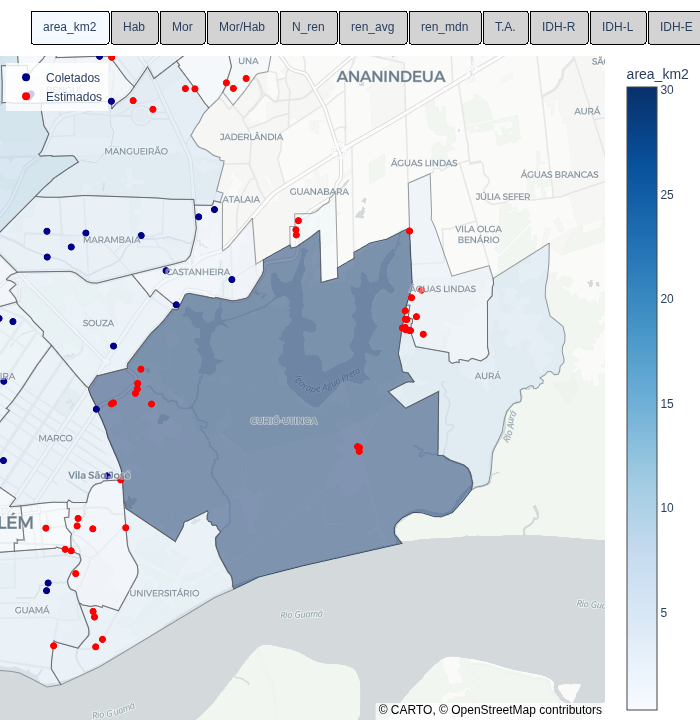

In [3]:
# Categorizar
def categorizar_dies(dies):
    if dies == 0:
        return 1
    elif 1 <= dies <= 3:
        return 2
    elif 4 <= dies <= 6:
        return 3
    else:  # dies >= 7
        return 4

gdf_merged['Dies_cat'] = gdf_merged['DIEs'].apply(categorizar_dies)

#=
variaveis = ['area_km2','Hab','Mor','Mor/Hab','N_ren','ren_avg','ren_mdn','T.A.','IDH-R','IDH-L','IDH-E','IDH','PPR','DIEs','Dies_cat']
escalas = ["blues", "reds", "reds", "reds", "RdYlGn", "RdYlGn", "RdYlGn","rdbu", "rdbu", "rdbu", "rdbu", "rdbu","rdbu",'RdYlGn_r', "RdYlGn_r"]

centro_lat,centro_lon =-1.427897, -48.4162631

# Juntando os dois gráficos em 1
fig = go.Figure()

# Adicionar um trace para cada variável do choropleth (inicialmente visível apenas o primeiro)
for i, (var, scale) in enumerate(zip(variaveis, escalas)):
    fig.add_trace(go.Choroplethmap(
        geojson=gdf_merged.geometry.__geo_interface__,
        locations=gdf_merged.index,
        z=gdf_merged[var],
        colorscale=scale,
        visible=(i == 0),  # Apenas o primeiro visível
        marker_opacity=0.5,
        hovertext=gdf_merged["Bairro"],
        hoverinfo="text+z",
        colorbar_title=var,
        name=var,
        showlegend=False
    ))

# Adicionar os pontos de descarte - DADOS
pontos_dados = gpd_p[gpd_p["Cor"] == "Dados"]
fig.add_trace(go.Scattermap(
    lat=pontos_dados["lat"],
    lon=pontos_dados["lon"],
    mode='markers',
    marker=dict(
        size=8,
        color="darkblue",
    ),
    hovertext=pontos_dados["Bairro"],
    hoverinfo="text",
    name="Coletados",
    showlegend=True,
    visible=True
))

# Adicionar os pontos de descarte - ESTIMADOS
pontos_estimados = gpd_p[gpd_p["Cor"] == "Estimados"]
fig.add_trace(go.Scattermap(
    lat=pontos_estimados["lat"],
    lon=pontos_estimados["lon"],
    mode='markers',
    marker=dict(
        size=8,
        color="red",
    ),
    hovertext=pontos_estimados["Bairro"],
    hoverinfo="text",
    name="Estimados",
    showlegend=True,
    visible=True
))

# Criar botões HORIZONTAIS apenas para as variáveis do choropleth
buttons = []
for i, var in enumerate(variaveis):
    visibility = [False] * len(variaveis) + [True, True]  # Ambos os pontos sempre visíveis
    visibility[i] = True  # Choropleth selecionado visível
    
    buttons.append(
        dict(
            label=var,
            method="update",
            args=[
                {"visible": visibility},
                {"title": f"Variável: {var}"}
            ]
        )
    )

# Calcular posições horizontais igualmente espaçadas
num_botoes = len(variaveis)
largura_botao = 0.12
espacamento = (1 - (largura_botao * num_botoes)) / (num_botoes + 1)

fig.update_layout(
    map_style="carto-positron",
    map_center={"lat": centro_lat, "lon": centro_lon},
    map_zoom=12,
    # Botões horizontais acima do mapa
    updatemenus=[
        dict(
            type="buttons",
            direction="right",  # Direção horizontal
            buttons=buttons,
            x=0.05,  # Posição inicial
            y=1.02,  # Acima do mapa
            xanchor="left",
            yanchor="bottom",
            bgcolor="lightgray",
            bordercolor="black",
            borderwidth=1,
            pad={"r": 10, "t": 10},
            showactive=True
        )
    ],
    height=720,
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)"
    )
)

#fig.show(config={"scrollZoom": True})

fig.show('png')
# fig.show(
#     'png',
#     width=1280, 
#     height=720)
